Import Lib

In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf, plot_ccf,acf,ccf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

Load Data

In [7]:
ng_price = pd.read_csv('Problem Set 1/Natural_Gas_Data prices.csv')
ng_posit = pd.read_csv('Problem Set 1/Natural_Gas_Data positioning.csv')
ng_inventory = pd.read_csv('Problem Set 1/inventory.csv')
ng_cdd = pd.read_csv('Problem Set 1/CDD.csv')
ng_hdd = pd.read_csv('Problem Set 1/HDD.csv')
ng_posit

,Date,Producers,Swaps,Managed Money,Other Reportable,Non-reportable,Abs total,Percent Producers,Percent Swaps,Percent Managed Money,Percent Other Reportable,Percent Non-reportable
0,28-05-2024,-131177,208043,16569.0,-106664,13229,475682.0,-28%,44%,3%,-22%,3%
1,21-05-2024,-98374,203117,-11080.0,-105552,11889,430012.0,-23%,47%,-3%,-25%,3%
2,14-05-2024,-76147,196725,-56029.0,-79739,15190,423830.0,-18%,46%,-13%,-19%,4%
3,07-05-2024,-71495,204519,-103800.0,-46433,17209,443456.0,-16%,46%,-23%,-10%,4%
4,30-04-2024,-87800,202811,-89013.0,-43465,17467,440556.0,-20%,46%,-20%,-10%,4%
...,...,...,...,...,...,...,...,...,...,...,...,...
329,06-02-2018,-57332,46937,219380.0,-237569,28584,589802.0,-10%,8%,37%,-40%,5%
330,30-01-2018,-54611,69365,166634.0,-200131,18743,509484.0,-11%,14%,33%,-39%,4%
331,23-01-2018,-61586,108196,111252.0,-180228,22366,483628.0,-13%,22%,23%,-37%,5%
332,16-01-2018,-52120,163529,45077.0,-181788,25302,467816.0,-11%,35%,10%,-39%,5%


Functions 

In [8]:
def get_abs_pos(plt = False) :
    if not plt : ng_posit['Abs total']
    ng_posit['Abs total'].plot()

def get_all_perc_pos (plt = False) :
    perc_columns = ng_posit.columns[7:]
    remove_perc = lambda x : x.strip('%')
    ng_posit_perc = ng_posit[perc_columns].apply(lambda x : x.apply(remove_perc))
    ng_posit_perc = ng_posit_perc.astype(float)
    if not plt : return ng_posit_perc
    ng_posit_perc.plot(figsize=(12,6))

def net_pos (plt = True) :
    ng_posit_perc = get_all_perc_pos(plt= False)
    if not plt : return ng_posit_perc.iloc[0] 
    ng_posit_perc.sum(axis = 1).plot()

def get_fut_contract (c1 =False ,c2 = False,plt = False) :
    if c1 and c2 : 
        if not plt : return  ng_price[['NG1','NG2']]
        ng_price[['NG1','NG2']].plot()
    if c1 and not c2 : 
        if not plt :  return ng_price['NG1']
        ng_price['NG1'].plot()
    if not c1 and c2 : 
        if not plt : return ng_price['NG2']
        ng_price['NG2'].plot()

    return      

def get_invetory_data(plt) :
    if not plt : return ng_inventory[ng_inventory.columns[1]]
    ng_inventory[ng_inventory.columns[1]].plot() 

def get_cdd_hdd (cdd = False , hdd = False,plt = False) :
    if cdd and hdd : 
        if not plt : return ng_hdd.HDD,ng_cdd.CDD
        ng_hdd.HDD.plot(),ng_cdd.CDD.plot()
    if cdd and not hdd : 
        if not plt : return ng_cdd.CDD
        ng_cdd.CDD.plot()
    if not cdd and hdd : 
        if not plt : ng_hdd.HDD
        ng_hdd.HDD.plot() 


def join_price_with_data(df) :
    global ng_price
    data_df = df.copy()
    data_df.set_index('Date',drop = True , inplace= True)
    ng_price = ng_price.join(data_df,on = 'Date')

def join_price_all_with_data () : 
    global ng_price
    
    join_price_with_data(ng_cdd)

    join_price_with_data(ng_hdd)

    ng_inventory.rename(columns = {ng_inventory.columns[1] : 'inventory' },inplace=True )
    join_price_with_data(ng_inventory)
    ng_price.inventory = ng_price.inventory.ffill()
    
    ng_posit[ng_posit.columns[7:]] = get_all_perc_pos()
    join_price_with_data(ng_posit)
    ng_price = ng_price.ffill()
    
    return  ng_price


def ccf_all (lags = 5) :
    all_df = join_price_all_with_data()
    all_df = all_df.dropna().reset_index(drop = True)
    cols = all_df[all_df.columns[3:]].columns
    
    rows = []
    for col in cols :
        corr_coef = np.mean(ccf(all_df['NG1'],all_df[col])[1:lags+1])
        rows.append([col,corr_coef,abs(corr_coef)])


    corr_df = pd.DataFrame(rows,columns = ['feature','corr_coef','abs_corr'])
    return corr_df.sort_values('abs_corr').reset_index(drop = True)    

FIRSTLY WE JOIN ALL FEATURES TO NATURAL GAS PRICES ON DATE . WHICH MAKES IT EASIER TO ANALYSE DATA AND BACKTEST.

In [426]:
ng_price = join_price_all_with_data()
ng_price

,Date,NG1,NG2,CDD,HDD,inventory,Producers,Swaps,Managed Money,Other Reportable,Non-reportable,Abs total,Percent Producers,Percent Swaps,Percent Managed Money,Percent Other Reportable,Percent Non-reportable
0,29-05-2024,2.592,2.835,3.4,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28-05-2024,2.590,2.825,4.4,1.1,NaN,-131177.0,208043.0,16569.0,-106664.0,13229.0,475682.0,-28.0,44.0,3.0,-22.0,3.0
2,24-05-2024,2.520,2.773,5.3,1.8,NaN,-131177.0,208043.0,16569.0,-106664.0,13229.0,475682.0,-28.0,44.0,3.0,-22.0,3.0
3,23-05-2024,2.657,2.923,5.2,1.5,78.0,-131177.0,208043.0,16569.0,-106664.0,13229.0,475682.0,-28.0,44.0,3.0,-22.0,3.0
4,22-05-2024,2.842,3.052,6.0,1.7,78.0,-131177.0,208043.0,16569.0,-106664.0,13229.0,475682.0,-28.0,44.0,3.0,-22.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,08-01-2018,2.835,2.772,0.0,27.4,-359.0,-55360.0,170973.0,5208.0,-146408.0,25587.0,403536.0,-14.0,42.0,1.0,-36.0,6.0
1617,05-01-2018,2.795,2.745,0.0,41.4,-359.0,-55360.0,170973.0,5208.0,-146408.0,25587.0,403536.0,-14.0,42.0,1.0,-36.0,6.0
1618,04-01-2018,2.880,2.813,0.0,39.7,-359.0,-55360.0,170973.0,5208.0,-146408.0,25587.0,403536.0,-14.0,42.0,1.0,-36.0,6.0
1619,03-01-2018,3.008,2.931,0.0,39.3,-359.0,-55360.0,170973.0,5208.0,-146408.0,25587.0,403536.0,-14.0,42.0,1.0,-36.0,6.0


<Axes: >

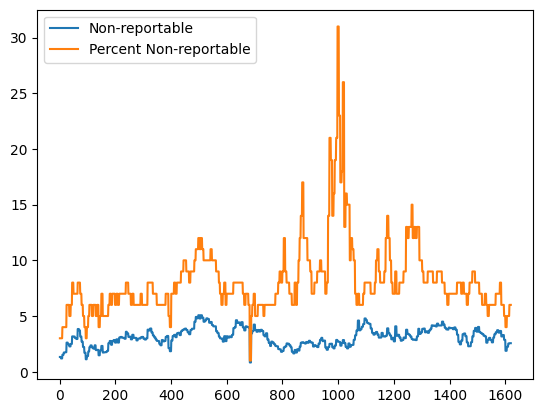

In [416]:
ng_price['Non-reportable'] = ng_price['Non-reportable']/10000
ng_price[['Non-reportable','Percent Non-reportable']].plot()

Cross-Correlation of Inventory Data With NG1 (nearest natural gas futures )

* plot shows how though in near term (till lag 30) the invertory is +ve corr 

* but on a longer terms (>lag 20), as inventory starts piling up (supply increase) the prices starts falling and vice-versa

* similar analysis can be done for each feature/data point


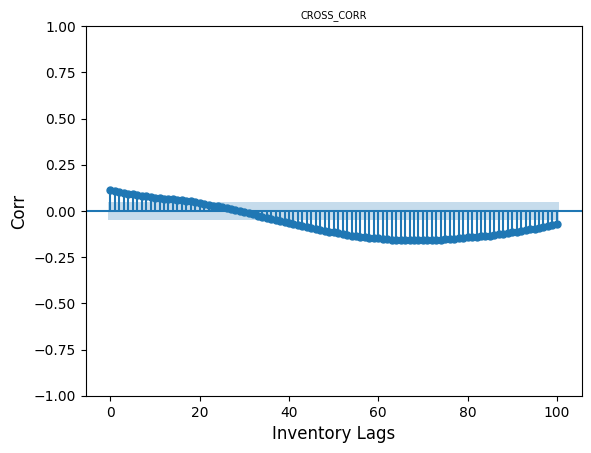

In [9]:
ng_price= join_price_all_with_data()
price = ng_price['NG1'].iloc[3:]
inventory = ng_price['inventory'].iloc[3:]
plot_ccf(price,inventory,lags = 100)
plt.xlabel('Inventory Lags', fontsize=12)
plt.ylabel('Corr', fontsize=12)
plt.title('CROSS_CORR', fontsize=7)
plt.show()

This the cross correlation for each feature . corr_coef (columns 1) is the average corr tilll lag 5.

In [441]:
ccf_all()

,feature,corr_coef,abs_corr
0,Percent Managed Money,0.022930,0.022930
1,Managed Money,0.052999,0.052999
2,Percent Non-reportable,-0.073861,0.073861
3,HDD,-0.090385,0.090385
4,Percent Other Reportable,-0.093717,0.093717
5,inventory,0.098508,0.098508
6,CDD,0.104013,0.104013
7,Other Reportable,-0.217888,0.217888
8,Percent Swaps,0.219221,0.219221
9,Percent Producers,-0.253583,0.253583


Analyze CDD AND HDD REGIME

As Temprature is one of the biggest factors moving Natural Gas prices. We Dig Deeper

Plot shows the Seasonality of CDD AND HDD and how they are inversly related

<Axes: >

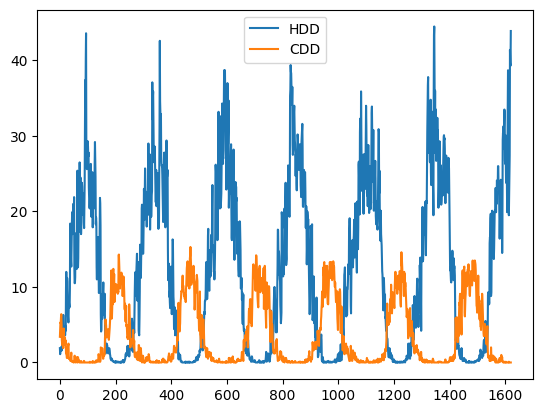

In [295]:
ng_price[['HDD','CDD']].plot()

1] >HDD  : Holding NG1 Futures when HDD is greater than thresold (0.5)

2] <HDD  : NG1 Future Holdings Sold when HDD lower than thresold

* below plot shows how holding NG1 on >HDD days has +ve pnl vs -ve pnl for holding on <HDD Days

Clear alpha here is >HDD

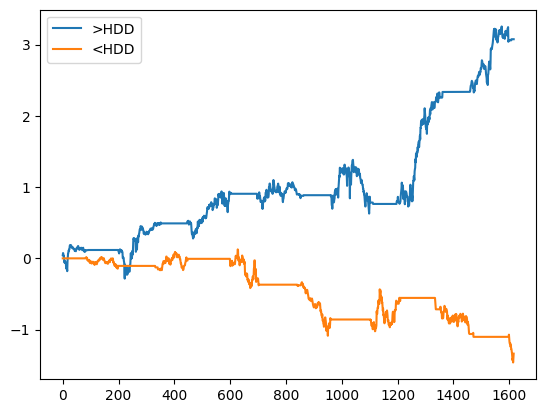

In [395]:
# HDD
ng_price['%'] = ng_price['NG1'].pct_change()
ng_price = ng_price[-1::-1]
ng_price['HDD'] = ng_price['HDD'].shift(1)
ng_price = ng_price.dropna().reset_index(drop = True)

ng_price['>'] = np.where(ng_price.HDD>5,ng_price['%'],0)
ng_price['<'] = np.where(ng_price.HDD<5,ng_price['%'],0)
ng_price['>'].cumsum().plot()
ng_price['<'].cumsum().plot()
plt.legend(['>HDD','<HDD'])


Similar Analysis on CDD shows inverse result (as they are inversly related)

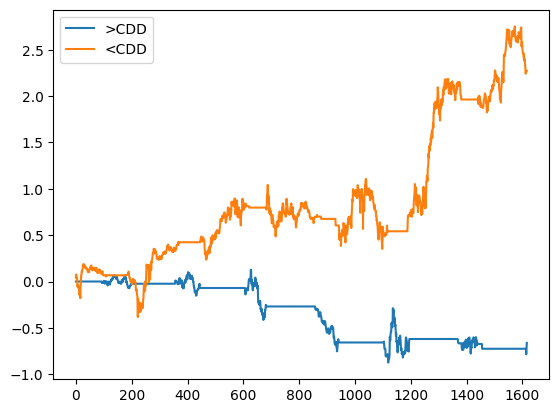

In [399]:
#CDD
ng_price['%'] = ng_price['NG1'].pct_change()
ng_price = ng_price[-1::-1]
ng_price['CDD'] = ng_price['CDD'].shift(1)
ng_price = ng_price.dropna().reset_index(drop = True)

ng_price['>'] = np.where(ng_price.CDD>5,ng_price['%'],0)
ng_price['<'] = np.where(ng_price.CDD<5,ng_price['%'],0)
ng_price['>'].cumsum().plot()
ng_price['<'].cumsum().plot()
plt.legend(['>CDD','<CDD'])

<Axes: >

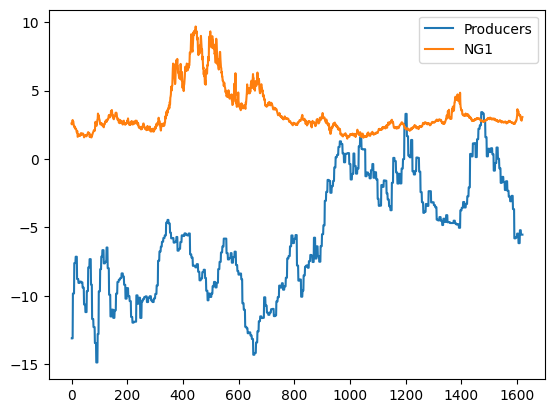

In [292]:
ng_price['Producers'] = ng_price['Producers']/10000
ng_price[['Producers','NG1']][-1::-1].plot()

INDICATOR Signal

below plot shows how positioning changes for various participants

when we sum all participats % contract across each date , we get a signal which oscilates between binaries 0,1,-1
This can be a arbitrary ssignal for strategy devlopment





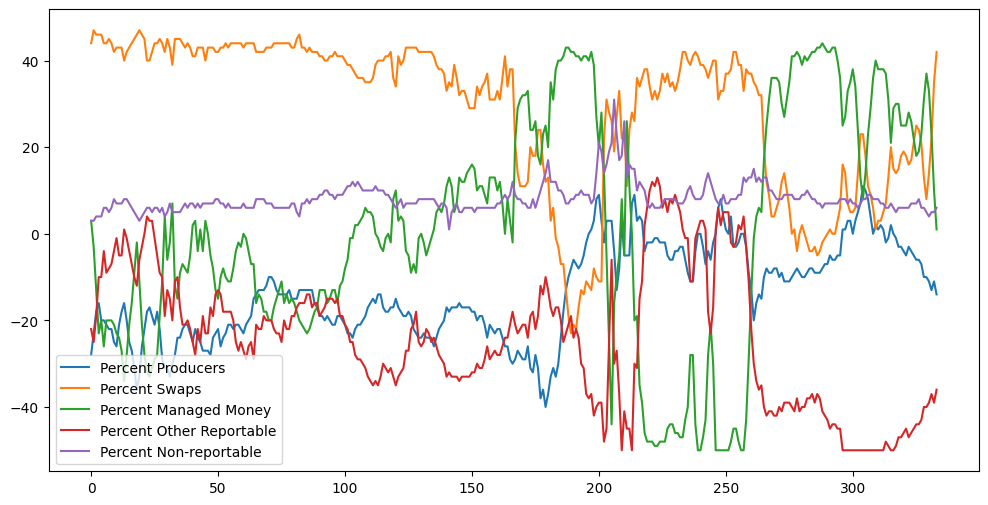

In [245]:
get_all_perc_pos(plt = True)

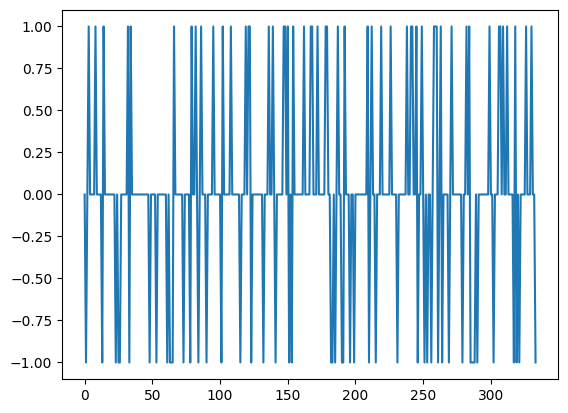

In [246]:
net_pos()

STRATEGY 1 : Multi-Variate Linear Regression MODEL 

below is the linear regression plot of x : Producers net Contract vs y : NG1 Prices

implication is that, then -ve correlated as Producers Usuall Hedge against ther Capacity

-1.4004310835626764e-05 2.564350072525561


Text(0, 0.5, 'NG1 price')

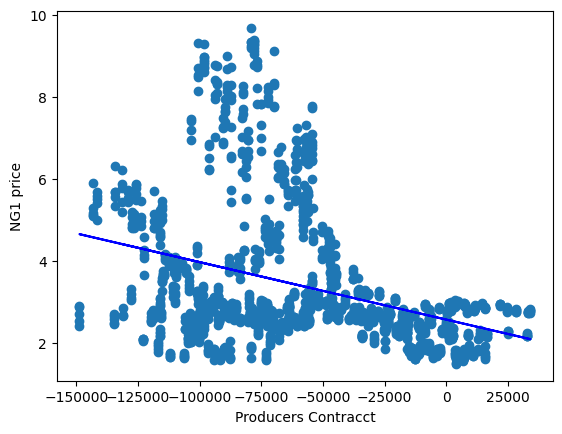

In [442]:
lr_model =  LinearRegression()
ng_price['Producers'] = ng_price['Producers'].shift(1)
ng_price.dropna(inplace = True)
lr_model.fit(ng_price[['Producers']],ng_price[['NG1']])

print(lr_model.coef_[0][0],lr_model.intercept_[0])

plt.scatter(ng_price[['Producers']],ng_price[['NG1']])
lr_line = ng_price[['Producers']]*lr_model.coef_[0][0] + lr_model.intercept_[0]
plt.plot(ng_price['Producers'],lr_line,color = 'blue')
plt.xlabel('Producers Contracct')
plt.ylabel('NG1 price')

We fit each Feature till lag 3 On a linear regresiion model . 

Multiple lr model fitted on lag 3 individual features make prediction of the price next day . If price predcition is > prev day's price we Long futures else short .

Prediction of multiple models are combined to get the output price

Train test slpit is 70% , The plot shows how the strategy has outperformed the NG1 BUY&HLD Futures .

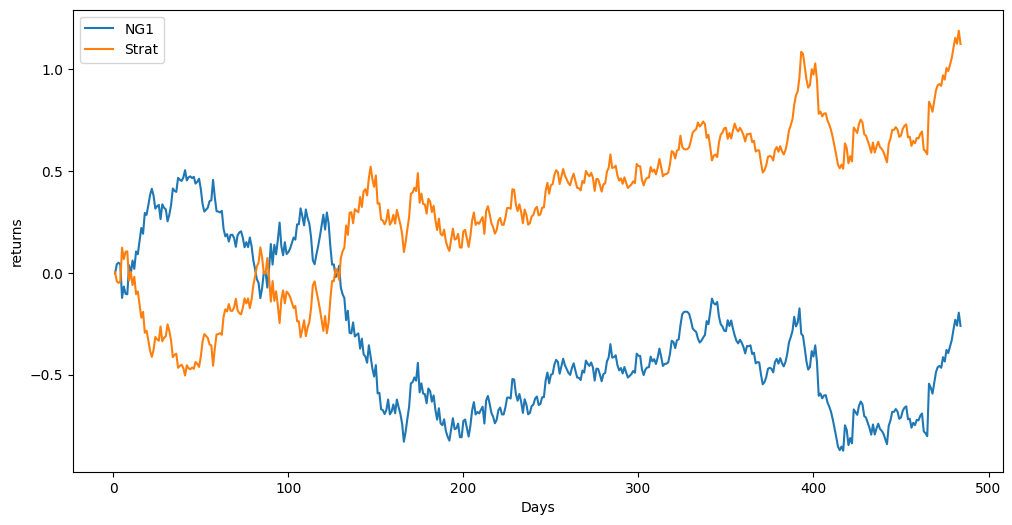

In [256]:
class backtest_ccf_strategy() :

    def __init__(self,split,cols ,lags=1) :
        self.split = split
        self.cols = cols
        self.lags = lags
        self.prepare_data()
        self.model_dict = {}

    def prepare_data(self) :   
        self.all_df = join_price_all_with_data()
        self.all_df = self.all_df[-1::-1]
        
        for col in self.cols :
            self.create_features(col,self.lags)

        self.all_df = self.all_df.dropna().reset_index(drop = True) 
    
    def lag_cols (self,col,lags) :
        return [ col + f'_lag{lag}' for lag in np.arange(1,lags+1) ]

    def create_features (self,col,lags) :
        new_cols = self.lag_cols(col,lags)
        #self.all_df[new_cols] = pd.concat([ self.all_df[[col]].shift(lag) for lag in np.arange(1,lags+1) ],axis = 1)
        df = pd.concat([ self.all_df[[col]].shift(lag) for lag in np.arange(1,lags+1) ],axis = 1)
        df.columns = new_cols
        self.all_df = pd.concat([self.all_df,df],axis = 1)
        

    def train_test_split(self) :
        self.train_df = self.all_df[:int(self.split*len(self.all_df))].reset_index(drop = True)
        self.test_df = self.all_df[int(self.split*len(self.all_df)):].reset_index(drop = True)

    def train_model (self,col,lags) :
        feat_df = self.train_df[self.lag_cols(col,lags)]
        lr_model =  LinearRegression()
        lr_model.fit(feat_df,self.train_df[['NG1']])
        
        #print(lr_model.coef_[0][0],lr_model.intercept_[0])
        return lr_model
    
    def train_all_models (self) :
        self.model_dict = { col : self.train_model(col,self.lags) for col in self.cols }


    def model_pred (self,col,features) :
        assert len(features) == self.lags
        lr_model = self.model_dict[col]

        return sum(lr_model.coef_[0]*features) + lr_model.intercept_[0]
    
    def do (self) :
        self.train_test_split()
        self.train_all_models()
        self.backtest_strat()
        self.plot_()
    
    def backtest_strat(self) :
        signals = []
        for indx in self.test_df.index :
            pred = []
            for col in self.cols :
                inputs = np.array(self.test_df[self.lag_cols(col,self.lags)].iloc[indx])
                pred_price = self.model_pred(col,inputs)
                prev_price = self.test_df['NG1'].iloc[indx-1]
                if pred_price >= prev_price :
                    pred.append(1)
                else :
                    pred.append(-1)
            
            signals.append(np.sign(sum(pred)))

        self.test_df['signal'] = signals


    def plot_ (self) :
        self.test_df['%'] = self.test_df['NG1'].pct_change()
        pnl = np.where(self.test_df.signal == 1 , self.test_df['%'],-self.test_df['%'])

        plt.figure(figsize = (12,6))
        plt.plot(self.test_df['%'].cumsum())
        plt.plot(pd.Series(pnl).cumsum())    
        plt.legend(['NG1','Strat'])    
        plt.xlabel('Days')
        plt.ylabel('returns')
        

obj = backtest_ccf_strategy(0.7,['Producers','Swaps','Abs total','Non-reportable'],lags = 3)
obj.do()        

STRATEGY 2 : FUTURES ARBITRAGE    

This is pure Arbitrage between Current and Next Month Contracts . In sample histogram is plotted and 1std thresold is fixed.

Spread = Next week Future (NG2) - Current Week Futures(NG1)

If spread is greater then thresold we short NG2 and Long NG1 

if spred is lower than - thresold we long NG2 and Short NG2

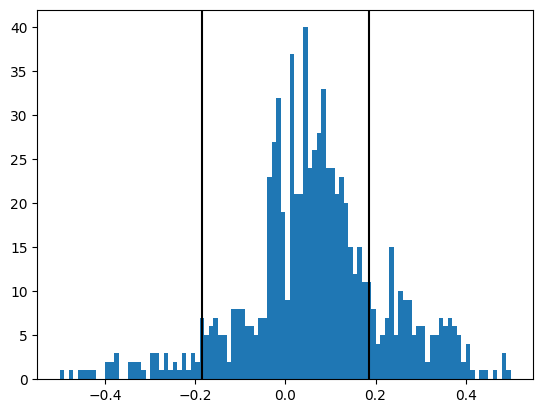

In [222]:
ng_price['arbit_price'] = (ng_price['NG2'] - ng_price['NG1'])
ng_in_sample = ng_price.iloc[:int(len(ng_price)*0.5)]
ng_out_sample = ng_price.iloc[int(len(ng_price)*0.5):]
std = ng_in_sample.arbit_price.std()
plt.hist(ng_in_sample.arbit_price,bins = 100, range = [-0.5,0.5])
plt.axvline(std,color = 'black')
plt.axvline(-std,color = 'black')

Text(0, 0.5, 'pnl')

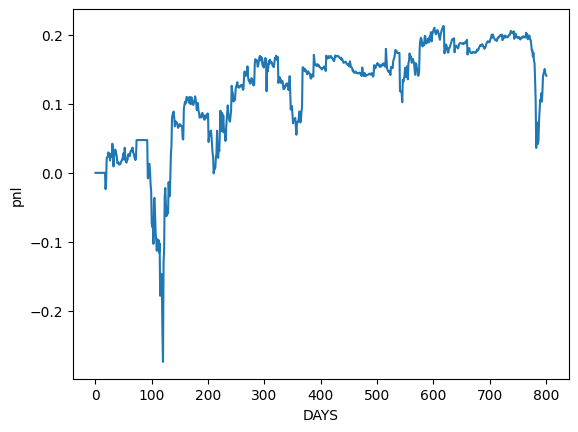

In [443]:
df = ng_out_sample.copy()
df['NG1_%'] = df['NG1'].pct_change(fill_method=None) 
df['NG2_%'] = df['NG2'].pct_change(fill_method=None) 
df = df.dropna().reset_index(drop = True)
signals = []
u_thresold = std
l_thresold = -std
pos = 0
for indx in df.index :
    if pos == 0 :
        if df['arbit_price'].iloc[indx] > u_thresold :
            pos = -1
        if df['arbit_price'].iloc[indx] < l_thresold :
            pos = 1
    if pos == 1 :
        if df['arbit_price'].iloc[indx] >= u_thresold*0.5 :
            pos = 0  
    if pos == -1 :
        if df['arbit_price'].iloc[indx] <= l_thresold*0.5 :
            pos = 0             
            
    signals.append(pos)


df['NG2_signal'] = signals
df['NG1_signal'] = -df['NG2_signal']

pnl = df['NG1_signal']*df['NG1_%'] + df['NG2_signal']*df['NG2_%'] 
plt.plot(pnl.cumsum())
plt.xlabel('DAYS')
plt.ylabel('pnl')